# Preliminary Analysis of Dominik's 93 Colour Patch Comparison Data

2022-Jan-28  
Ariel Zeleznikow-Johnston

In [1]:
# hardcoded values
n.compare = 320
cor_threshold = 0.5
n.stim = 93
catch_threshold = 70

In [2]:
Sys.setenv(RGL_USE_NULL = TRUE)
library(rlang)
library(rgl)
library(stringr)

In [3]:
library(remotes)
remotes::install_github("rstudio/webshot2")


Skipping install of 'webshot2' from a github remote, the SHA1 (dff26265) has not changed since last install.
  Use `force = TRUE` to force installation



In [4]:
install.packages("rsample")

package 'rsample' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpWC7vxT\downloaded_packages


In [5]:
library(webshot2)

In [6]:
library(entropy)

In [7]:
library(tidyverse)
install.packages("ramify")
library(dplyr)
library(ggplot2)
install.packages("reshape2")
library(viridis)
library(MASS)
install.packages("hrbrthemes")
library(scales)
library(broom)
install.packages("pglm")
library(gtools)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.4     v dplyr   1.0.8
v tidyr   1.2.0     v forcats 0.5.1
v readr   2.0.2     

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x purrr::%@%()         masks rlang::%@%()
x purrr::as_function() masks rlang::as_function()
x dplyr::filter()      masks stats::filter()
x purrr::flatten()     masks rlang::flatten()
x purrr::flatten_chr() masks rlang::flatten_chr()
x purrr::flatten_dbl() masks rlang::flatten_dbl()
x purrr::flatten_int() masks rlang::flatten_int()
x purrr::flatten_lgl() masks rlang::flatten_lgl()
x purrr::flatten_raw() masks rlang::flatten_raw()
x purrr::invoke()      masks rlang::invoke()
x dplyr::lag()         masks stats::lag()
x p

package 'ramify' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpWC7vxT\downloaded_packages
package 'reshape2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpWC7vxT\downloaded_packages


Loading required package: viridisLite


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




package 'hrbrthemes' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpWC7vxT\downloaded_packages



Attaching package: 'scales'


The following object is masked from 'package:viridis':

    viridis_pal


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




package 'pglm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpWC7vxT\downloaded_packages



Attaching package: 'gtools'


The following object is masked from 'package:rlang':

    chr




### Loading Data

In [8]:
# matching regex of any amount of characters then followed by .csv
files <- list.files(path="./data", pattern="*.csv", full.names=TRUE)
filesizes <- file.size(files)

# individual participant files use a unique ID to mark which colour pairs they saw
truthColourTableColumnNames <- c("r1", "g1", "b1", "r2", "g2", "b2")
truthColourTable <- read.csv("./colourcodes/colourcodes.csv", header=F)
names(truthColourTable) <- truthColourTableColumnNames

# not sure what the point of this is...?
files <- files[-(which(filesizes < 4))]

pilotdata <- sapply(files, read.csv, simplify=FALSE) %>% bind_rows(.id = "fileId")

In [9]:
# changing realcomparison from zero-indexed to one-indexed

participantsIDFrame <- data.frame(unique(pilotdata$participant))

pilotdata <- pilotdata %>% arrange("participant")

In [10]:
# variables of interest from collected data
trial_vars<- c( "participant", "practice_comparison", "pracsimilarity", "realcomparison", "similarity", "response_time", "trials_2.thisN") 
catch_vars<- c("participant", "catch_response_time", "catchnumberprac", "catchpracsimilarity", "catchnumber", "catchsimilarity", "catchRT", "catchtrialorder")
trialdata <- (pilotdata %>% filter(!is.na(realcomparison)))[trial_vars] # no catch trials
catchdata <- (pilotdata %>% filter(!is.na(catchnumber)))[catch_vars] # no main trials
trialdata = rename(trialdata, dissimilarity = similarity)

trialdata$realcomparison <- trialdata$realcomparison + 1 # fixing the indexing?

rgb2hex <- function(r, g, b) {rgb(r, g, b, maxColorValue = 255)}

In [11]:
# getting the colour pair comparison information

# compartmentalising the two dots presented to participants
firstColourSet <- truthColourTable[,truthColourTableColumnNames[1:3]]
secondColourSet <- truthColourTable[,truthColourTableColumnNames[4:6]]

names(firstColourSet) <- names(secondColourSet) <- c("r", "g", "b")

#conversion of 3 RGB columns in both colour tables to HEX for easier manipulation
firstColourSetHEX <- apply(firstColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
secondColourSetHEX <- apply(secondColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
                            
#conversion of 3 RGB columns in both colour tables to HEX for easier manipulation
firstColourSetHEX <- apply(firstColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
secondColourSetHEX <- apply(secondColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))

# colourSetHEX is used as a reference throughout the rest of the analysis for the colour pair comparisons     
colourSetHEX <- data.frame(firstColour = firstColourSetHEX, secondColour = secondColourSetHEX)


### Cleaning Data

##### Catch Trials

In [12]:
# catch trial scoring
#hist(catchdataParticipant$accuracy)


In [13]:
# assess whether participants passed
catch.assess <- function(catchdata){
    catchdata <- catchdata %>% mutate(is_valid_catch_response = if_else(catchnumber == catchsimilarity, 1, 0), is_invalid_catch_response = if_else(catchnumber != catchsimilarity, 1, 0))
    catchdataParticipant <- catchdata %>% group_by(participant) %>% 
      summarise(correct_responses=sum(is_valid_catch_response), incorrect_responses = sum(is_invalid_catch_response))

    catchdataParticipant$total <- catchdataParticipant$correct_responses + catchdataParticipant$incorrect_responses
    catchdataParticipant$accuracy <- (catchdataParticipant$correct_responses/catchdataParticipant$total) * 100
    return(catchdataParticipant)
}

# remove participants who scored below a certain threshold
catch.remove <- function(catchdata, trialdata, threshold){
    catch.participant <- catch.assess(catchdata)
    passed <- subset(catch.participant, accuracy >= threshold)$participant
    clean <- subset(trialdata, trialdata$participant %in% passed)
    return(clean)
}


In [14]:
# clean the trial data
clean.data <- catch.remove(catchdata,trialdata,catch_threshold) # using 80% threshold

##### Within-subject double pass consistency

In [15]:
# each participant should have completed 320 trials
count.remove <- function(data, threshold){
    count <- data %>% count(participant)
    passed <- subset(count, n == threshold)$participant
    clean <- subset(data, participant %in% passed)
    return(clean)
}

clean.data <- count.remove(clean.data,n.compare)

##### Within-subject double pass consistency

In [16]:
double.pass.check <- function(data){
    v1 <- data$dissimilarity[1:(n.compare/2)]
    v2 <- data$dissimilarity[(n.compare/2+1):n.compare]
    return(cor(v1,v2))
}

pass.remove <- function(data, threshold=cor_threshold){
    IDs <- unique(data$participant)
    passed <- vector()
    for(id in IDs){
        tryCatch(
            {
                if(double.pass.check(subset(data, participant == id)) >= threshold){
                    passed <- c(passed,id)
                }
            },
            error=function(cond){
                message(paste("Something went wrong with correlations for participant:",id))
            }
        )
        
    }
    clean <- subset(data, participant %in% passed)
    return(clean)
}

clean.data <- pass.remove(clean.data)

Warning message in cor(v1, v2):
"the standard deviation is zero"
Something went wrong with correlations for participant: 60fdee1f5bb38a56c58631bc



### Descriptive plots & statistics

##### Matrix Visualisations

Setting up the matrix

In [17]:
# read in the colour comparison truth table
colourSetHEX <- data.frame(firstColour = firstColourSetHEX, secondColour = secondColourSetHEX)

rowsTotalSetHEX <- rbind(data.frame(colour = firstColourSetHEX), data.frame(colour = secondColourSetHEX)) %>% group_by_all %>% count

# preliminary check that the data has been read in correctly
countOfUniqueRowsFirstSet <- length(unique(firstColourSetHEX))
countOfUniqueRowsSecondSet <- length(unique(secondColourSetHEX))
countOfUniqueRowsTotalSet <- length(rowsTotalSetHEX$colour)

In [18]:
# set lower triangle of matrix to NA - this gives heatmap its unique upper triangle
upperTriangularMatrix <- upper.tri(matrix(1, ncol = countOfUniqueRowsTotalSet, nrow = countOfUniqueRowsTotalSet), 
                              diag = FALSE)
upperTriangularMatrix[upperTriangularMatrix == 1] <- NA
color.mat.df <- data.frame(upperTriangularMatrix)
color.mat <- upperTriangularMatrix

#head(uniqueColourCountDF)

In [19]:
# setting all give colours as both row and column names
colnames(color.mat.df) <- rownames(color.mat.df) <- rowsTotalSetHEX$colour
colnames(color.mat) <- rownames(color.mat) <- rowsTotalSetHEX$colour

Matrix plot of group mean for each comparison

In [20]:
# get mean dissimilarity for each colour comparison
group.mean <- clean.data %>% 
                group_by(realcomparison) %>% 
                summarise(across(dissimilarity, mean, na.rm = TRUE))

In [21]:
# create a mean dissimilarity dataframe using realcomparison indexing
group.avg.df <- function(data, colors.df){
    means.df <- data %>%
                group_by(realcomparison) %>%
                summarise(across(dissimilarity, mean, na.rm = TRUE))
    # sorting 
    means.df$realcomparison <- as.numeric(means.df$realcomparison)
    # fill in NA values
    if(nrow(means.df) < 4371){
        full <- 1:4371
        incomplete <- means.df$realcomparison
        missing <- setdiff(full,incomplete)
        addon <- tibble(realcomparison = missing, dissimilarity = NA)
        means.df <- rbind(means.df,addon)
        
    }
    # get it in the right format for making a matrix
    means.df <- means.df[order(means.df$realcomparison),]
    colors.df$value <- means.df$dissimilarity
    return(colors.df)
}

In [22]:
gp.mean.data <- colourSetHEX
gp.mean.data$value <- group.mean$dissimilarity

In [23]:
#head(gp.mean.data)

In [24]:
# fill matrix
matrix.df.fill <- function(data,matrix.df){
    for(i in 1:nrow(data)){
        #print(i)
        row <- data[i,]
        #print(matrix.df[row$firstColour,row$secondColour])
        matrix.df[row$firstColour,row$secondColour] <- row$value
        matrix.df[row$secondColour,row$firstColour] <- row$value # symmetric
        #print(matrix.df[row$firstColour,row$secondColour])
    }
    return(matrix.df)
}

In [25]:
group.mean.mat.df <- matrix.df.fill(gp.mean.data,color.mat.df)


In [26]:
# for visualisation purposes, make a column value indicating correlation with first row
row.cor <- function(df){
    v.cor <- vector()
    for(i in 1:nrow(df)){
        v.cor <- c(v.cor, cor(df[1],df[i]))
    }    
    return(v.cor)
}

row.factors <- function(colors, correlations){
    colors$cor <- correlations
    ordered <- colors[order(-colors$cor),]
    return(ordered$colour)
}

row.facs <- row.factors(rowsTotalSetHEX,row.cor(group.mean.mat.df))

In [171]:
head(group.mean.mat.df)

,#010300,#022C88,#02529A,#032040,#03406F,#034E49,#086E79,#09384C,#0A3B38,#0C4FA2,⋯,#F6F7F1,#FAAF99,#FAC88D,#FB702E,#FBA628,#FBEC77,#FCDD2A,#FF8F00,color1,color2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
#010300,0.000000,5.1818182,5.9000000,3.8214286,5.1666667,4.733333,5.117647,3.7500000,4.029412,5.350000,⋯,6.500000,6.605263,6.333333,6.833333,6.675000,6.500000,5.733333,6.619048,#010300,#010300
#022C88,5.181818,0.1956522,1.1578947,2.5833333,0.9375000,3.181818,2.500000,2.5625000,4.923077,1.600000,⋯,6.233333,5.800000,6.000000,6.545455,6.000000,5.928571,5.657895,6.088235,#022C88,#022C88
#02529A,5.900000,1.1578947,0.7352941,2.9210526,1.5714286,3.541667,2.075000,2.9444444,3.250000,0.500000,⋯,6.035714,5.472222,6.142857,6.092593,6.538462,6.038462,6.666667,5.631579,#02529A,#02529A
#032040,3.821429,2.5833333,2.9210526,0.8076923,1.7692308,3.472222,2.875000,0.8333333,2.200000,3.157895,⋯,6.136364,6.352941,6.033333,6.229167,6.025000,6.058824,6.041667,6.263158,#032040,#032040
#03406F,5.166667,0.9375000,1.5714286,1.7692308,0.7941176,3.277778,2.846154,1.4500000,3.136364,1.781250,⋯,6.000000,5.788462,6.357143,6.208333,6.200000,5.961538,5.625000,6.000000,#03406F,#03406F
#034E49,4.733333,3.1818182,3.5416667,3.4722222,3.2777778,1.045455,2.115385,2.1250000,0.800000,2.900000,⋯,6.342105,6.406250,5.307692,5.750000,5.970588,5.785714,5.625000,6.343750,#034E49,#034E49


In [27]:
group.mean.mat.df$color1 <- rowsTotalSetHEX$colour
group.mean.mat.df$color2 <- rowsTotalSetHEX$colour

In [28]:
#head(group.mean.mat.df)

In [29]:
group.mean.df <- gather(group.mean.mat.df, color1, mean,
                        rowsTotalSetHEX$colour[1]:rowsTotalSetHEX$colour[nrow(rowsTotalSetHEX)],
                       factor_key=TRUE)

In [30]:
group.mean.df$color1 <- with(group.mean.df, factor(color1, levels = row.facs))
group.mean.df$color2 <- with(group.mean.df, factor(color2, levels = row.facs))

In [31]:
# plot the matrix
matrix.mean <- ggplot(group.mean.df, aes(x = color1, y = color2, fill = mean)) + geom_raster() + 
    theme(axis.text.x = element_text(colour=row.facs, angle=90),
         axis.text.y = element_text(colour=row.facs)) +
    scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,7),
                        breaks=c(0,1,2,3,4,5,6,7))
ggsave("mean dissim matrix.png",matrix.mean,height=15,width=17)
    

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


In [32]:
row.facs

[1] "#010300" "#293028" "#171639" "#032040" "#09384C" "#331F3B" "#0A3B38"
 [8] "#2F2874" "#261D6E" "#034E49" "#163D1F" "#03406F" "#3F597A" "#595F51"
[15] "#4E486C" "#5D6355" "#430F59" "#022C88" "#0C4FA2" "#52253C" "#39319E"
[22] "#02529A" "#086E79" "#642B7C" "#716B92" "#5D4263" "#445507" "#367467"
[29] "#427AC4" "#7171C9" "#5F7AA7" "#487F55" "#207427" "#685A14" "#9DA193"
[36] "#591D1F" "#3394B7" "#86A2C9" "#8B5F92" "#B4BAAC" "#5891A2" "#7E8274"
[43] "#41A79A" "#73B7C3" "#68A899" "#8F5AA8" "#5FC16E" "#40A144" "#758E00"
[50] "#7D0B45" "#76450B" "#9796C0" "#83B37F" "#A3E2AC" "#8DCFC1" "#84932A"
[57] "#782918" "#7C3D4E" "#D8DACD" "#B28AB7" "#AAC901" "#9C1C53" "#A25739"
[64] "#F6F7F1" "#AEBE5A" "#96484B" "#C5DD24" "#B06079" "#9B081A" "#A51A01"
[71] "#DA0B27" "#AF972D" "#AE783C" "#FCDD2A" "#AC6401" "#C4577A" "#D8E26A"
[78] "#E83406" "#D3BE51" "#E088A1" "#FBEC77" "#AA8F02" "#F4D000" "#D2797D"
[85] "#E26164" "#E67E72" "#FF8F00" "#F699A1" "#FAC88D" "#FB702E" "#FBA628"
[92] "#E49A5B" "#FAAF99"

Check for triangle inequality violations

In [33]:
head(group.mean.mat.df)

,#010300,#022C88,#02529A,#032040,#03406F,#034E49,#086E79,#09384C,#0A3B38,#0C4FA2,⋯,#F6F7F1,#FAAF99,#FAC88D,#FB702E,#FBA628,#FBEC77,#FCDD2A,#FF8F00,color1,color2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
#010300,0.000000,5.1818182,5.9000000,3.8214286,5.1666667,4.733333,5.117647,3.7500000,4.029412,5.350000,⋯,6.500000,6.605263,6.333333,6.833333,6.675000,6.500000,5.733333,6.619048,#010300,#010300
#022C88,5.181818,0.1956522,1.1578947,2.5833333,0.9375000,3.181818,2.500000,2.5625000,4.923077,1.600000,⋯,6.233333,5.800000,6.000000,6.545455,6.000000,5.928571,5.657895,6.088235,#022C88,#022C88
#02529A,5.900000,1.1578947,0.7352941,2.9210526,1.5714286,3.541667,2.075000,2.9444444,3.250000,0.500000,⋯,6.035714,5.472222,6.142857,6.092593,6.538462,6.038462,6.666667,5.631579,#02529A,#02529A
#032040,3.821429,2.5833333,2.9210526,0.8076923,1.7692308,3.472222,2.875000,0.8333333,2.200000,3.157895,⋯,6.136364,6.352941,6.033333,6.229167,6.025000,6.058824,6.041667,6.263158,#032040,#032040
#03406F,5.166667,0.9375000,1.5714286,1.7692308,0.7941176,3.277778,2.846154,1.4500000,3.136364,1.781250,⋯,6.000000,5.788462,6.357143,6.208333,6.200000,5.961538,5.625000,6.000000,#03406F,#03406F
#034E49,4.733333,3.1818182,3.5416667,3.4722222,3.2777778,1.045455,2.115385,2.1250000,0.800000,2.900000,⋯,6.342105,6.406250,5.307692,5.750000,5.970588,5.785714,5.625000,6.343750,#034E49,#034E49


In [34]:
# get rid of extraneous columns
mean.mat.df <- subset(group.mean.mat.df, select = c(-color1, -color2))
mean.mat <- data.matrix(mean.mat.df)


In [35]:
mean.mat[lower.tri(mean.mat, diag = FALSE)] <- NA
#head(mean.mat)

In [36]:
# test for triangle inequality violation given three values
tri.violate <- function(vals){
        
    vals <- sort(vals) # sort from smallest to largest dissimilarity
    if(anyNA(vals)){
        return(FALSE) # don't bother with NAs, e.g. in lower triangle of matrix
    }
    if(vals[3] > (vals[1] + vals[2])){ # I think this is all that's needed
        return(TRUE)
    } else if (vals[2] > vals[1] + vals[3]) { # don't think this is possible
        return(TRUE)
    } else if (vals[1] > vals[2] + vals[1]){ # don't think this is possible
        return(TRUE)
    }
    else {
        return(FALSE)
    }
}

In [37]:
# perform the test across all of a subject's judgments
mat.tri.violate <- function(mat){
    n.stim <- nrow(mat)
    violations <- list()
    i.violate = 1
    for(i in 1:(n.stim-3)){
        for(j in (i+1):(n.stim-2)){
            k = 1
            while(k < (n.stim-j+1)){
                
                #testing
                #print(paste("i:",i,"j:",j,"k:",k,"k+j",k+j))
                
                stimuli <- c(i,j,j+k)
                d.ij <- mat[i,j]
                d.jk <- mat[j,j+k]
                d.ik <- mat[i,j+k]
                vals <- c(d.ij, d.jk, d.ik)
                if(tri.violate(vals)){
                    violations[[i.violate]] <- stimuli
                    i.violate <- i.violate+1
                }
                k <- k + 1
            }
        }
    }
    return(violations)
}

In [38]:
score.tri.violate <- function(mat){
    count <- length(mat.tri.violate(mat))
    n.stim <- nrow(mat)
    n.combo <- length(combinations(n.stim,3)) / 2 # is this right? Removing symmetry redundancy?
    return(count/n.combo)
}

In [39]:
score.tri.violate(mean.mat)

[1] 0.003919876

In [92]:
violations <- mat.tri.violate(mean.mat)


[[1]]
[1]  1  2 12

[[2]]
[1]  1  3 10

[[3]]
[1]  1  3 12

[[4]]
[1]  1  4 12

[[5]]
[1]  1  5 12

[[6]]
[1]  1  6 15

In [95]:
head(violations)
length(violations)
violations[[2]]

[[1]]
[1]  1  2 12

[[2]]
[1]  1  3 10

[[3]]
[1]  1  3 12

[[4]]
[1]  1  4 12

[[5]]
[1]  1  5 12

[[6]]
[1]  1  6 15

[1] 763

[1]  1  3 10

In [159]:
# visualise the triangle inequality densities
test <- mean.mat
test[1:93,1:93] <- NA

# convert a list of triangle inequality violations back to a matrix density
violations.mat <- function(mat){
    violations <- mat.tri.violate(mat)
    
    # setup output
    out <- mat
    out[1:93,1:93] <- 0 # initialised to zero
    
    # fill in the matrix
    for(x in 1:length(violations)){
        line <- violations[[x]]
        
        i <- line[1]
        j <- line[2]
        k <- line[3]
        
        out[i,j] <- out[i,j] + 1
        out[j,k] <- out[j,k] + 1
        out[i,k] <- out[i,k] + 1
    }
    
    # return violations matrix
    return(out)
}

violations.mat <- violations.mat(mean.mat)



In [160]:
# algorithm looks at all possible combinations, which involves doubling-up on some colour pairs
# remove double ups
# add the transpose of the bottom-left of the matrix to the top right, remove bottom-left

#violations.mat[lower.tri(violations.mat, diag = FALSE)]
#t.violations.mat <- t(violations.mat)
#t.violations.mat[lower.tri(t.violations.mat)] <- 0
#violations.mat <- violations.mat + t.violations.mat
#head(violations.mat)
#violations.mat[lower.tri(violations.mat)] <- 0
##head(violations.mat)

In [161]:
#head(violations.mat)
violations.df <- gather(as.data.frame(violations.mat), color1, count,
                        rowsTotalSetHEX$colour[1]:rowsTotalSetHEX$colour[nrow(rowsTotalSetHEX)],
                       factor_key=TRUE)

violations.df$color1 <- group.mean.df$color1
violations.df$color2 <- group.mean.df$color2
#head(violations.df)

In [162]:
# plot the triangle inequality matrix

# symmeterise data
#violations.df.sym <- violations.df
#violations.df.sym$C1 <- violations.df$color1
#violations.df.sym$C2 <- violations.df$color2
#violations.df.sym$color1 <- violations.df.sym$C2
#violations.df.sym$color2 <- violations.df.sym$C1
#violations.df.sym <- subset(violations.df.sym, select = -c(C1, C2))
#print(colnames(mean.df))
#print(colnames(sym.data))
#violations.df <- rbind(violations.df,violations.df.sym)

#violations.df$color1 <- with(violations.df, factor(color1, levels = row.facs)) # reorder the color labels according to row.facs, another vector
#violations.df$color2 <- with(violations.df, factor(color2, levels = row.facs))

triangle.inequality.plot <- ggplot(violations.df, aes(x = color1, y = color2, fill = count)) + geom_raster() + 
    theme(axis.text.x = element_text(colour=row.facs, angle=90),
         axis.text.y = element_text(colour=row.facs)) +
        scale_fill_gradientn(colours = c("white","orange","green"))
ggsave("triangle inequality matrix.png",triangle.inequality.plot,height=15,width=17)

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


Check normalised trace

In [40]:
group.norm.trace <- sum(diag(mean.mat))/nrow(mean.mat)
group.norm.trace

[1] 0.5870308

##### Dissimilarity Distributions

Warning message:
"Removed 2 rows containing missing values (geom_bar)."


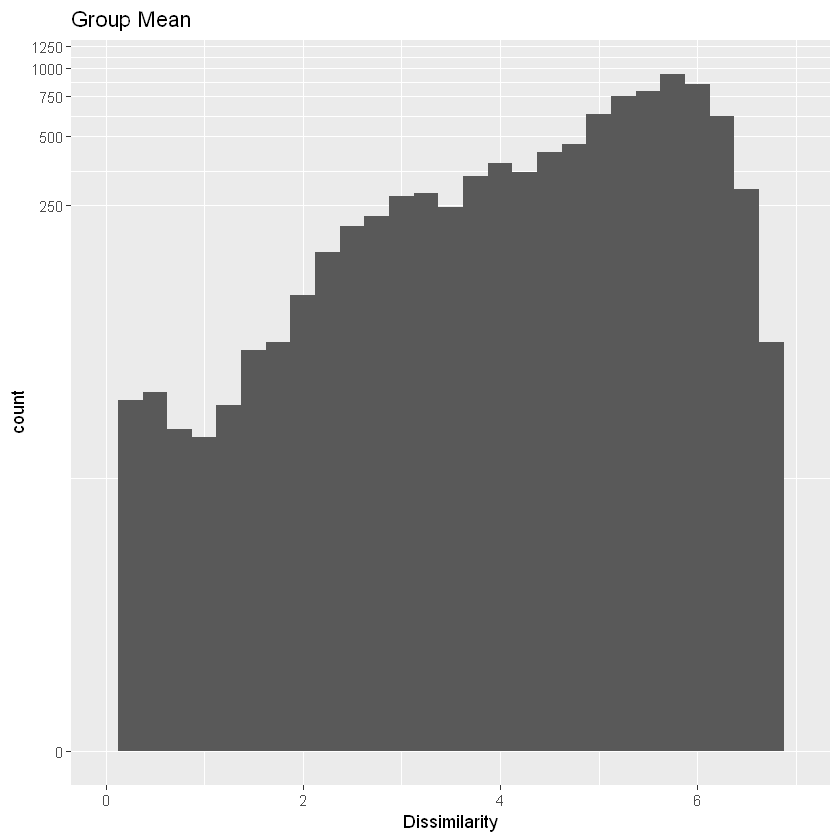

In [41]:
# distribution of dissimilarity values
dissim.distr <- ggplot(group.mean.df, aes(x=mean)) + geom_histogram(binwidth=0.25) +
                xlim(0,7) + xlab('Dissimilarity') + ggtitle('Group Mean') + scale_y_continuous(trans='log1p')
dissim.distr

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 108 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 2 rows containing missing values (geom_bar)."


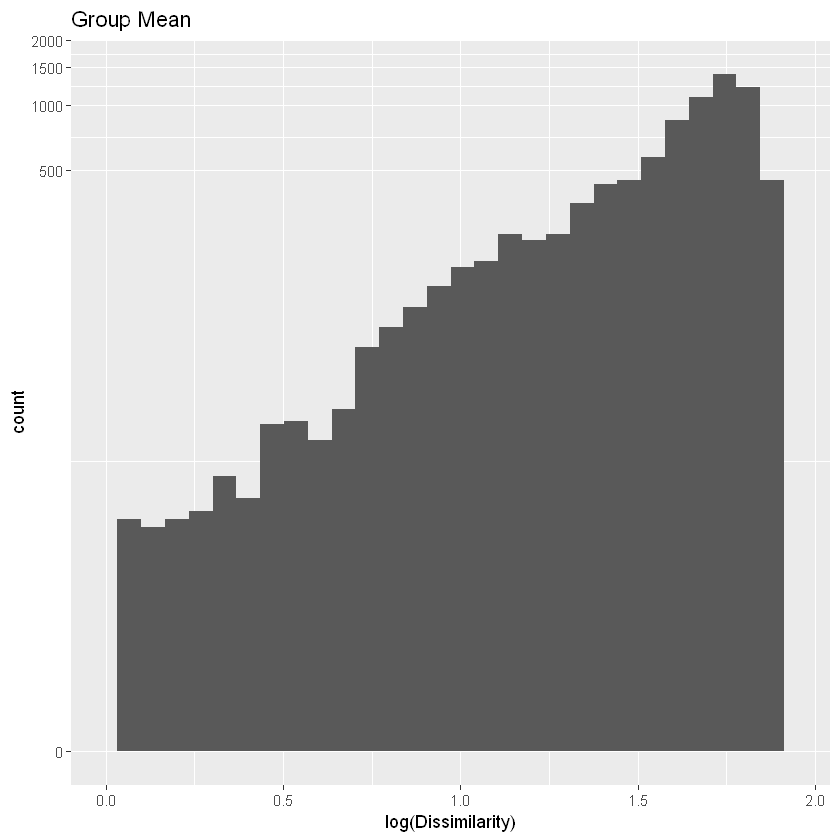

In [42]:
log.dissim.distr <- ggplot(group.mean.df, aes(x=log(mean))) + geom_histogram() +
                xlim(0,log(7)) + xlab('log(Dissimilarity)') + ggtitle('Group Mean') + scale_y_continuous(trans='log1p')
log.dissim.distr

### Additional visualisations

Data distribution of a beta distribution - can I visualise the data using MDS after putting the data through a beta distribution link function?

In [43]:
# set up the MDS matrix
data2dist <- function(mat){
    return(as.dist(t(mat), diag=TRUE))
}

data.dist <- data2dist(mean.mat)

In [86]:
visualise3d <- function(dist,name,classical=TRUE,diagnose=FALSE,error=FALSE,v.error=NULL){
    
    
    dir.create(name)
    if(classical){
        mean.mds <- cmdscale(dist, k = 3, eig=TRUE)
    } else {
        name <- paste(name,'non-metric',sep='_')
        mean.mds <- isoMDS(dist, k = 3, eig=TRUE, maxit=100)
    }
    
    # Create x, y, z refs
    data.x <- mean.mds$points[,1]
    data.y <- mean.mds$points[,2]
    data.z <- mean.mds$points[,3]
    # plot
    colors <- colnames(mean.mat)

    if(error){ # plot the size of the dots to be indicative of the size of the error provided
        
        temp.df <- data.frame(data.x,data.y,data.z,colors,v.error) # set up initial dataframe
        
        df.list <- split(temp.df, v.error) # split into a list of dataframes based on error size
        #print(df.list[[1]])
        
        # setup the plot
        plot <- with(temp.df, plot3d(data.x,data.y,data.z,
                                     col = colors, size = 0))
        
        # use a separate call to points3d() to update the plot point size for each plot
        for(i in seq_along(df.list)){
            with(df.list[[i]], points3d(data.x,data.y,data.z,
                                     col = colors, size = v.error*20))
        }
        
    } else {
        plot <- plot3d(data.x,data.y,data.z, col = colors, size = 10)
    }
    

    dir.create(paste(name,'/animation/',sep=''))

    by = 10
    if(diagnose){
        by=120
    }
        
    for(i in seq(0,350, by)){ # make an animation
        view3d(theta=i)
        save.name <- paste(name,'/animation/',str_pad(i,4,pad='0'),'.png',sep='')
        snapshot3d(save.name, fmt = 'png',
                width = 1000, height = 1000)
    }
}

# ImageMagick code to turn it into a .gif
#magick -delay 40 *.png -loop 0 movie.gif

In [44]:
plot(mean.mds$eig, col = 'red', xlim=c(1,10), ylim = c(0,13000))

ERROR: Error in plot(mean.mds$eig, col = "red", xlim = c(1, 10), ylim = c(0, : object 'mean.mds' not found


In [ ]:
mean.mds$GOF

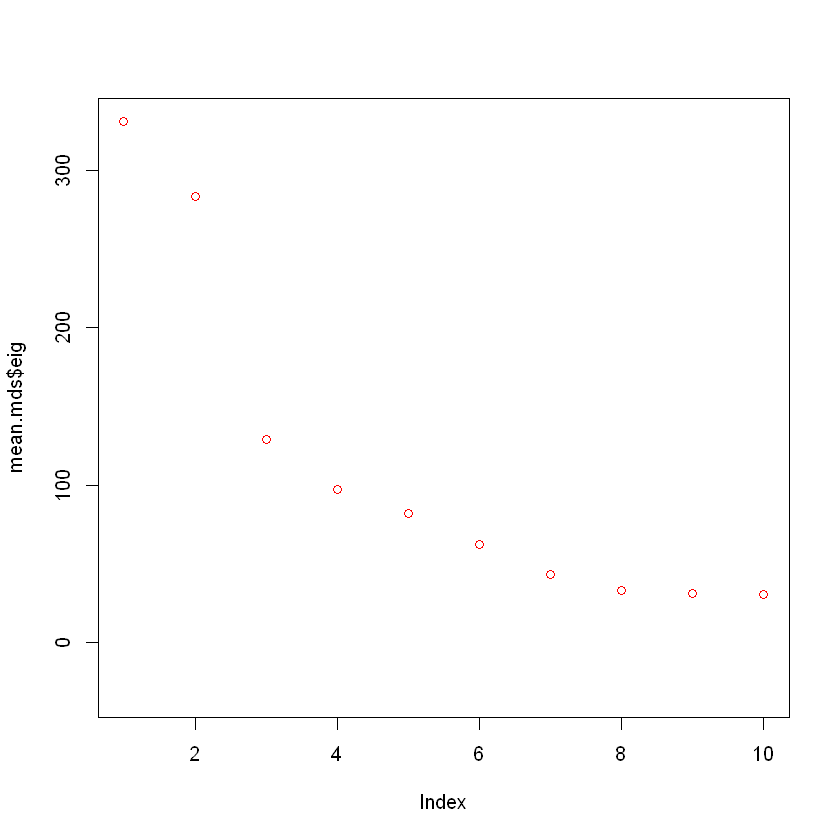

In [46]:
mean.mds <- cmdscale(data.dist, k = 3, eig=TRUE)
plot(mean.mds$eig, col = 'red', xlim=c(1,10))

In [ ]:
log.mean.mds <- cmdscale(log(data.dist+1), k = 3, eig=TRUE)

In [ ]:
plot(log.mean.mds$eig, col = 'red', xlim=c(1,10))

In [ ]:
visualise3d(log(data.dist),'log mean')

In [ ]:
visualise3d((data.dist),'raw fixed')

In [ ]:
visualise3d((data.dist),'raw', classical=FALSE)

In [ ]:
Probability <- c(0,0.45,0.55,0,0) 
plot(Probability, col = 'blue', ylim=c(0,1), type = 'l')

### Model Prediction Accuracy Tests Through Cross-Validation

Ok, the plan is:  
1. Divide aggregate colour comparisons data into ~10 sets, producing 10 full dissimilarity matrices but with only 10% of the judgments per entry  
2. Derive MDS solution for 9 of the sets  
3. Use 9 sets to calculate expected dissimilarity between colours (expected dissimilarity matrix)  
4. Calculate SSE between constructed matrix and holdout set  
5. Compare raw data vs. log data by normalising total variance of reserved set  


In [ ]:
# split the data into 10 sets
split.data <- function(data, n_split,method='data'){
    data$realcomparison <- as.character(data$realcomparison)
    output <- list()
    data$ID <- seq.int(nrow(data))
    if(method=='data'){
        for(i in 1:n_split){
        
            out <- data %>%
                group_by(realcomparison) %>%
                sample_frac(1/n_split,replace=FALSE) # select fraction of data
            
            data[!(data$ID %in% out$ID),] # remove selected data from original data
            out <- subset(out, select = -c(ID)) # remove ID column
            #print(head(out)) # testing
            output[[i]] <- out # add to output list
        }
        
    }   else if (method=='participant'){
            # this works algorithmically, but is not useful
            # random participant splitting means that some comparisons are not
            # sampled for any number of groups greater than 2, which is useless
            # I'll need to write a cleverer algorithm for this
            participants <- sample(unique(data$participant))
            n_participants <- length(participants)
            for(i in 1:n_split){
                temp_participants <- participants[ floor((i-1)*n_participants/n_split + 1) : floor((i*n_participants/n_split)) ]
                out <- subset(data, participant %in% temp_participants)
                output[[i]] <- out # add to output list
            }
    } else if (method=='mean'){
        # split the participants based on their mean dissimilarity rating value
        
        mean.df <- data %>% group_by(participant) %>% summarise(measure = mean(dissimilarity))
        mean.df.sorted <- mean.df[order(mean.df$measure),]
        IDs.sorted <- mean.df.sorted$participant
        
        for(i in 1:n_split){
            #print(i)
            low <- (floor((i-1)*length(IDs.sorted)/n_split)) +1
            #print(low)
            #print(low/length(IDs.sorted))
            high <- (floor(i*length(IDs.sorted)/n_split))
            #print(high)
            #print(high/length(IDs.sorted))
            temp.IDs <- IDs.sorted[low:high]
            out <- subset(data, participant %in% temp.IDs)
            output[[i]] <- out # add to output list
        }
    }
    
    return(output)
}

In [ ]:
#shuffled_data= clean.data[sample(1:nrow(clean.data)), ]

#temp.grouped  <- shuffled_data %>%
 # group_by(participant,realcomparison) %>%
  #mutate(isTrainingSet = (row_number() <= 0.1 * n())) %>%
  #ungroup()

#firstHalf <- filter(temp.grouped , isTrainingSet)
#secondHalf <- filter(temp.grouped , !isTrainingSet)

In [ ]:
#nrow(firstHalf)
#print(length(unique(firstHalf$realcomparison)))
#print(length(unique(clean.data$realcomparison)))

In [ ]:
#temp <- clean.data
#temp$realcomparison <- as.character(temp$realcomparison)
#splitObj <- initial_split(temp,
 #                        prop = 0.25,
  #                       strata=realcomparison)
#nrow(clean.data)
#print(length(unique(clean.data$realcomparison)))
#train <- training(splitObj)
#nrow(train)
#print(length(unique(train$realcomparison)))

In [ ]:
#clean.split.participant <- split.data(clean.data, 10, method='participant')

In [ ]:
clean.split.data <- split.data(clean.data, 10, method='data')


In [ ]:
mean.matrix.list <- function(split.list){
    n <- length(split.list)
    output <- list()
    
    for(i in 1:n){
        mean.df <- group.avg.df(split.list[[i]], colourSetHEX)
        mean.mat <- matrix.df.fill(mean.df, color.mat.df)
        output[[i]] <- mean.mat
    }
    return(output)
}

In [ ]:
split.mats.data <- mean.matrix.list(clean.split.data)


In [ ]:
for(i in 1:length(clean.split.data)){
    print(length(unique(clean.split.data[[i]]$realcomparison)))
}

In [ ]:
for(i in 1:length(clean.split.participant)){
    print(length(unique(clean.split.participant[[i]]$realcomparison)))
}

In [ ]:
#split.mats.participant <- mean.matrix.list(clean.split.participant)

In [45]:
# plot a matrix
mean.matrix.plot <- function(df,name,log=FALSE,symmetry=TRUE,skip.mean=FALSE,normalised=FALSE){
    if(skip.mean){
        mean.df <- df
    } else{
        mean.df <- group.avg.df(df, colourSetHEX)
    }
    #print(log)
    #print(head(mean.df))
    #row.facs <- row.factors(rowsTotalSetHEX,row.cor(mean.df))
    #mean.df$color1 <- rowsTotalSetHEX$colour
    #mean.df$color2 <- rowsTotalSetHEX$colour
    mean.df$color1 <- with(mean.df, factor(firstColour, levels = row.facs)) # reorder the color labels according to row.facs, another vector
    mean.df$color2 <- with(mean.df, factor(secondColour, levels = row.facs))
    
    if(symmetry){
        sym.data <- mean.df
        sym.data$C1 <- mean.df$color1
        sym.data$C2 <- mean.df$color2
        sym.data$color1 <- sym.data$C2
        sym.data$color2 <- sym.data$C1
        sym.data <- subset(sym.data, select = -c(C1, C2))
        #print(colnames(mean.df))
        #print(colnames(sym.data))
        mean.df <- rbind(mean.df,sym.data)
    }
    
    if(log){
        name <- paste(name,'_log_',sep='')
        plot <- ggplot(mean.df, aes(x = color1, y = color2, fill = log(value+1))) + 
        geom_raster() + ggtitle('log(dissimilarity+1)') +
        theme(axis.text.x = element_text(colour=row.facs, angle=90), # sets the individual colours for the text for each colour
             axis.text.y = element_text(colour=row.facs)) +
        scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,log(7+1)),
                        breaks=c(0,1,2,3,4,5,6,7),
                        na.value='green')
    } else if(normalised){
        plot <- ggplot(mean.df, aes(x = color1, y = color2, fill = value)) + 
        geom_raster() + ggtitle('dissimilarity') +
        theme(axis.text.x = element_text(colour=row.facs, angle=90),
             axis.text.y = element_text(colour=row.facs)) +
        scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,1),
                        breaks=c(0,0.5,1),
                        na.value='green')
    } else {
        plot <- ggplot(mean.df, aes(x = color1, y = color2, fill = value)) + 
        geom_raster() + ggtitle('dissimilarity') +
        theme(axis.text.x = element_text(colour=row.facs, angle=90),
             axis.text.y = element_text(colour=row.facs)) +
        scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,7),
                        breaks=c(0,1,2,3,4,5,6,7),
                        na.value='green')
    }
    name <- paste(name,'.png',sep='')
    ggsave(name,plot,height=15,width=17)
}

In [46]:
# plot a set of matrices in a folder
plot.set.mat <- function(mat.list,name,log=FALSE){
    name <- paste('mat_set/',name,'/',sep='')
    dir.create(name)
    for(i in 1:length(mat.list)){
        mat_name <- paste(name,i,sep='')
        mean.matrix.plot(mat.list[[i]],mat_name,log=log)
    }
}

In [47]:
#plot.set.mat(clean.split,'CV log',log=TRUE)
#plot.set.mat(clean.split.participant)

In [48]:
# convert a similarity judgment dataframe to a distance matrix for MDS
dist.create <- function(data){
        #print(head(data))
        mean.data.temp <- group.avg.df(data,colourSetHEX)
        dist.temp <- matrix.df.fill(mean.data.temp,color.mat.df)
        #print(head(dist.temp))
        #dist.temp$color1 <- rowsTotalSetHEX$colour
        #dist.temp$color2 <- rowsTotalSetHEX$colour
        #return(dist.temp)
        dist.mat.temp <- as.dist(t(dist.temp), diag=TRUE)
        #print(head(dist.mat))
        return(dist.mat.temp)
}

In [ ]:
# make a set of 3D visualisations
plot.set.3D <- function(data.list, name, log=FALSE,quick=TRUE){
    folder.str <- 'CV 3D sets/'
    dir.create(folder.str)
    if(log){
        name <- paste(name,'_log',sep='')
    }
    dir.create(paste(folder.str,name,sep=''))
    
    for(i in 1:length(data.list)){
        subfolder.str <- paste(folder.str,name,'/',i,sep='')
        dir.create(subfolder.str)
        
        dist.mat <- dist.create(data.list[[i]])
        
        print(subfolder.str)
        if(log){
            visualise3d(log(dist.mat+1),subfolder.str,diagnose=quick)
        } else {
            visualise3d(dist.mat,subfolder.str,diagnose=quick)
        }
    }
}

In [ ]:
# put everything together, do a certain number of splits
cv.visual <- function(data,n_split,name,log=FALSE,quick=TRUE){
    data.temp <- split.data(data, n_split,method='data')
    name <- paste(name,'_n_split_',n_split,sep='')
    plot.set.3D(data.temp,name,log=log,quick=quick)
    plot.set.mat(data.temp,name,log=log)
}

In [ ]:
#cv.visual(clean.data,2,'raw',quick=FALSE)
#cv.visual(clean.data,1,'log',log=TRUE,quick=FALSE)

In [ ]:
#plot.set.3D(clean.split.data,'raw')
#plot.set.3D(clean.split.data,'log',log=TRUE) 

#### Calculate correlations when splitting the data

Let's just compare the correlation and SSE between partitions of the data

Two different ways Nao will want to see for doing this:  
* Holdout judgments (e.g. 10% of judgments in the test set)
* Holdout participants (e.g. 10% of participants in the test set)

##### Holdout Judgments

Make a group mean matrix using 10-90% of the data in 10% increments, observe performance on predicting the judgments in the 10% holdout set

In [ ]:
# format the training & test data
cv.data.judge <- split.data(clean.data, 10, method='data')
test.data <- cv.data.judge[[10]]

train.10 <- group.avg.df(cv.data.judge[[1]], colourSetHEX)
test.data.avg <- group.avg.df(test.data, colourSetHEX)

In [ ]:
# plot the correlation between two datasets
cor.plot <- function(train,test,log=FALSE,xlabel='Training data',ylabel='Test data'){
    vals.df <- as.data.frame(c(train,test))

    if(log){
        vals.df$value <- log(vals.df$value+1)
        vals.df$value.1 <- log(vals.df$value.1+1)
    }
    plot <- ggplot(data = vals.df, aes(x = value, y = value.1)) + geom_point() +
            xlab(xlabel) + ylab(ylabel) +
            geom_smooth(method = 'lm', alpha = 0.15) +
            xlim(0,7) + ylim(0,7)
    print(plot)
    return(vals.df)
}

In [ ]:
# calculate standard squared erro
SSE <- function(lm){
    out <- sum((lm$fitted.values - mean(lm$fitted.values))^2)
    print(paste("SSE:",out))
    return(out)
}

In [ ]:
var(test.data.avg$value)
var(log(test.data.avg$value+1))

In [ ]:
data.90 <- rbind(cv.data.judge[[1]],
                 cv.data.judge[[2]],
                 cv.data.judge[[3]],
                 cv.data.judge[[4]],
                 cv.data.judge[[5]],
                 cv.data.judge[[6]],
                 cv.data.judge[[7]],
                 cv.data.judge[[8]],
                 cv.data.judge[[9]],
                )

In [ ]:
train.90 <- group.avg.df(data.90, colourSetHEX)


In [ ]:
raw.10 <- cor.plot(train.10,test.data.avg, log=FALSE)
raw.90 <- cor.plot(train.90, test.data.avg, log=FALSE)

In [ ]:
test1 <- cor.plot(train.10,test.data.avg, log=TRUE)
test2 <- cor.plot(train.90, test.data.avg, log=TRUE)

In [ ]:
cor(test1$value,test1$value.1)
cor(test2$value,test2$value.1)

In [ ]:
lm.10.raw <- lm(value~value.1, data = raw.10) # 10% training data
summary(lm.10.raw)
SSE(lm.10.raw)
SSE(lm.10.raw)/var(test.data.avg$value)

In [ ]:
lm.90.raw <- lm(value~value.1, data = raw.90) # 90% training data
summary(lm.90.raw)
SSE(lm.90.raw)/var(test.data.avg$value)

In [ ]:
lm.10.log <- lm(value~value.1, data = test1) # 10% training data
summary(lm.10.raw)
SSE(lm.10.log)
SSE(lm.10.log)/var(log(test.data.avg$value+1))

In [ ]:
lm.90.log <- lm(value~value.1, data = test2) # 90% training data
summary(lm.90.log)
SSE(lm.90.log)
SSE(lm.90.log)/var(log(test.data.avg$value+1))

##### Holdout Participants

Make a group mean matrix using 90% of participants, observe performance on predicting the judgments in the 10% holdout set

In [ ]:
cv.data.judge <- split.data(clean.data, 2, method='participant')

In [ ]:
# format the training & test data
train.90 <- group.avg.df(training(cv.data.judge), colourSetHEX)
test.data <- testing(cv.data.judge)

test.data.avg <- group.avg.df(test.data, colourSetHEX)

In [ ]:
raw.90 <- cor.plot(train.90, test.data.avg, log=FALSE)

In [ ]:
test2 <- cor.plot(train.90, test.data.avg, log=TRUE)

In [ ]:
cor(raw.90$value,raw.90$value.1)
cor(test2$value,test2$value.1)

In [ ]:
lm.90.raw <- lm(value~value.1, data = raw.90) # 90% training data
summary(lm.90.raw)
SSE(lm.90.raw)/var(test.data.avg$value)

In [ ]:
lm.90.log <- lm(value~value.1, data = test2) # 90% training data
summary(lm.90.log)
SSE(lm.90.log)
SSE(lm.90.log)/var(log(test.data.avg$value+1))

#### Calculate predicted distances from the MDS models

Ok, now let's see how well this works when we derive the dissimilarity matrix from the MDS model. We're going to lose some performance due to throwing away some information, but let's see how well it works

##### MDS Model to Dissimilarity Matrix

In [163]:
# euclidean distance
euclidean <- function(a, b){return(sqrt(sum((a-b)^2)))}

In [164]:
# find the dissimilarity between two colours in an MDS model
dissim.dist <- function(colour1, colour2, mds, method='euclidean'){
    x <- mds$points[colour1,]
    y <- mds$points[colour2,]
    if(method=='euclidean'){
        val <- euclidean(x, y)
        return(val) 
    }
}

In [165]:
# populate a dissimilarity df using an MDS model

mds2df <- function(mds, method='euclidean'){
    empty <- colourSetHEX
    empty$value <- NA
    for(row in 1:nrow(empty)){
        empty[row,3] <- dissim.dist(empty[row,1],
                           empty[row,2],
                           mds=mds,method=method)
    }
    return(empty)
}

In [166]:
test <- mds2df(mean.mds)

In [170]:
head(test)
nrow(test)

,firstColour,secondColour,value
,<chr>,<chr>,<dbl>
1,#E088A1,#E088A1,0.0000000
2,#E088A1,#C4577A,0.7191488
3,#E088A1,#B06079,0.9987285
4,#E088A1,#9C1C53,2.0135018
5,#E088A1,#7C3D4E,2.0592994
6,#E088A1,#7D0B45,2.3037880


[1] 4371

In [168]:
mean.matrix.plot(test,'lonni demo',skip.mean=TRUE)

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


In [ ]:
head(test.data.avg)
head(test)

In [ ]:
bum <- cor.plot(test.data.avg,test)

50-50 split, 3D Euclidean Model

In [ ]:
# format the training & test data
cv.data.judge <- split.data(clean.data, 2, method='participant')

test.data <- cv.data.judge[[2]]
test.data.avg <- group.avg.df(test.data, colourSetHEX)

#print(head(cv.data.judge)) # testing

train.50 <- group.avg.df(cv.data.judge[[1]], colourSetHEX)
train.50.mat <- matrix.df.fill(train.50,color.mat.df)

#print(train.50.mat) # testing
#print(nrow(train.50.mat))
#print(ncol(train.50.mat))

train.50.mds <- cmdscale(data2dist(train.50.mat),k=3, eig=TRUE)
#print(head(train.50.mds))
train.50.mds2df <- mds2df(train.50.mds)

plot <- cor.plot(train.50.mds2df,test.data.avg,
                 xlabel='Model Prediction',ylabel='Holdout Data')

In [ ]:
head(train.50.mds2df)$value[2]

In [ ]:
# find the error
error_mds <- function(test.data, model){
    sum = 0
    for(i in 1:nrow(test.data)){
        e = (test.data$value[i] - model$value[i])^2
        sum = sum + e
    }
    return(sum)
}

In [ ]:
error_mds(test.data.avg, train.50.mds2df)

In [ ]:
error_mds(train.50, train.50.mds2df)

In [ ]:
SSE(train.50.mds2df)

In [ ]:
lm.50 <- lm(value~value.1, data = plot)

In [ ]:
summary(lm.50)
SSE(lm.50)
SSE(lm.50)/var(test.data.avg$value)

#### Analysis across multiple dimensions

In [ ]:
# plot how e changes as dimensionality increases
dim.e <- function(data, dims=10, groups=2, method='data'){
    temp.data <- split.data(data, groups, method)
    
    test.data <- temp.data[[length(temp.data)]]
    test.data.avg <- group.avg.df(test.data, colourSetHEX)
    
    train.data <- group.avg.df(temp.data[[1]],colourSetHEX)
    train.data.mat <- matrix.df.fill(train.data, color.mat.df)
    
    e_train_list <- vector()
    e_test_list <- vector()
    for(i in 1:dims){
        train.mds <- cmdscale(data2dist(train.data.mat),k=i,eig=TRUE)
        train.mds2df <- mds2df(train.mds)
        e_test <- error_mds(test.data.avg,train.mds2df)
        e_train <- error_mds(train.data,train.mds2df)
        e_test_list[i] <- e_test
        e_train_list[i] <- e_train
    }
    print(plot(e_test_list, xlab='Dimension',ylab='Error',main='Test'))
    print(plot(e_train_list, xlab='Dimension',ylab='Error',main='Train'))
    return(list(e_test_list,e_train_list))
}

In [ ]:
test <- dim.e(clean.data, dims=10, method='data')

In [ ]:
participant <- dim.e(clean.data, dims=10, method='participant')

In [ ]:
participant

In [ ]:
test

### Genji Collaboration Analysis

" split the 93 color similarity matrix into 2 halfs, one from subject 1-250's mean, and the other for 251-500's mean"

In [ ]:
participant.halves <- split.data(clean.data, 2, method='participant')

In [ ]:
#half.1 <- group.avg.df(participant.halves[[1]], colourSetHEX)
#half.2 <- group.avg.df(participant.halves[[2]], colourSetHEX)

In [ ]:
mat1 <- matrix.df.fill(half.1, color.mat.df)
mat2 <- matrix.df.fill(half.2, color.mat.df)

In [279]:
plot_color_mat <- function(df,name,duplicate=TRUE){
    if(duplicate){ # sometimes only have 4371 values, but want to duplicate for plotting purposes
        df2 <- df
        df2$firstColour <- df$secondColour
        df2$secondColour <- df$firstColour
        df <- rbind(df,df2)
    }
    plot <- ggplot(df, aes(x = firstColour, y = secondColour, fill = value)) + geom_raster() +
    theme(axis.text.x = element_text(colour=row.facs, angle=90),
         axis.text.y = element_text(colour=row.facs)) +
    scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,7),
                        breaks=c(0,1,2,3,4,5,6,7),
                        na.value='green')
    ggsave(paste(name,".png"),plot,height=15,width=17)
    return(plot)
}

In [ ]:
#plot_color_mat(half.1,'half_1')
#plot_color_mat(half.2,'half_2')

In [ ]:
#test

In [ ]:
write.csv(x=half.1, "participant_group_1_mean_response_long.csv")
write.csv(x=half.2, "participant_group_2_mean_response_long.csv")

In [ ]:
write.table(mat1, "participant_group_1_mean_response_matrix.csv",sep=',')
write.table(mat2, "participant_group_2_mean_response_matrix.csv",sep=',')

"Then, scarmbled."

In [ ]:
mat1.scramble <- matrix(sample(as.matrix(mat1)),nrow=nrow(mat1))
write.table(mat1.scramble, "participant_group_1_mean_response_matrix_SCRAMBLED.csv",sep=',')

In [ ]:
#mat1.scramble

"split the groups based on variance"  
NB: I think entropy is actually a better measure

In [ ]:
head(clean.data)

In [ ]:
binary.test.max <- c(rep(0,40),rep(7,40))
binary.test.min <- c(rep(0,40),rep(1,40))
graded.test <- c(rep(c(0,1,2,3,4,5,6,7),8))

In [ ]:
var(binary.test.max)
var(binary.test.min)
var(graded.test)

In [ ]:
entropy.empirical(binary.test.max)
entropy.empirical(binary.test.min)
entropy.empirical(graded.test)
entropy.empirical(sample(graded.test))

In [ ]:
entropy.df <- clean.data %>% group_by(participant) %>% summarise(entropy = entropy.empirical(dissimilarity))
hist(entropy.df$entropy, 
     breaks=seq(3.5,6,by = 0.05),
    xlim=c(4.5,5.8)
    )

In [ ]:
variance.df <- clean.data %>% group_by(participant) %>% summarise(variance = var(dissimilarity))
hist(variance.df$variance,
    xlim=c(0,12),
    breaks=seq(0,12, by=0.5))

In [ ]:
test <- subset(clean.data, participant == '59bd3c6e3a9ab60001119ae5')

In [ ]:
simhistplot <- function(df){
    
   plot <- ggplot(df, aes(x = dissimilarity)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8) +
    ggtitle(paste('ID:',df$participant[1],' | ',
                  'Variance:',round(var(df$dissimilarity),2),' | ',
                  'Entropy:',round(entropy.empirical(df$dissimilarity),2)
                 ))
    return(plot)
}

var(test$dissimilarity)
entropy.empirical(test$dissimilarity)

simhistplot(test)

In [ ]:
plot.hist.all <- function(df){
    IDs <- sort(unique(df$participant))
    
    dir.create('subjects_histograms/')
    
    for(id in IDs){
        plot <- simhistplot(subset(clean.data, participant == id))
        
        save.name <- paste('subjects_histograms/',id,'.png',sep='')
        
        ggsave(save.name,plot,height=10,width=10)
    }
}

In [ ]:
plot.hist.var <- function(df){
    IDs <- sort(unique(df$participant))
    
    var.df <- df %>% group_by(participant) %>% summarise(variance = var(dissimilarity))
    var.df.sorted <- var.df[order(var.df$variance),]
    IDs.sorted <- var.df.sorted$participant
    
    dir.create('subjects_variance_sort/')
    
    count = 0
    for(id in IDs.sorted){
        count = count + 1
        
        plot <- simhistplot(subset(clean.data, participant == id))
        
        save.name <- paste('subjects_variance_sort/',str_pad(count,5,pad='0'),'_',id,'.png',sep='')
        
        ggsave(save.name,plot,height=10,width=10)
    }
}

In [ ]:
plot.entropy.var <- function(df){
    IDs <- sort(unique(df$participant))
    
    var.df <- df %>% group_by(participant) %>% summarise(entropy = entropy.empirical(dissimilarity))
    var.df.sorted <- var.df[order(var.df$entropy),]
    IDs.sorted <- var.df.sorted$participant
    
    dir.create('subjects_entropy_sort/')
    
    count = 0
    for(id in IDs.sorted){
        count = count + 1
        
        plot <- simhistplot(subset(clean.data, participant == id))
        
        save.name <- paste('subjects_entropy_sort/',str_pad(count,5,pad='0'),'_',id,'.png',sep='')
        
        ggsave(save.name,plot,height=10,width=10)
    }
}

In [ ]:
plot.measure.var <- function(df,measure){
    IDs <- sort(unique(df$participant))
    
    if(measure == 'mean'){
        var.df <- df %>% group_by(participant) %>% summarise(measure = mean(dissimilarity))
        folder.name <- 'subjects_mean_sort/'
    }
    var.df.sorted <- var.df[order(var.df$measure),]
    IDs.sorted <- var.df.sorted$participant
    
    dir.create(folder.name)
    
    count = 0
    for(id in IDs.sorted){
        count = count + 1
        
        plot <- simhistplot(subset(clean.data, participant == id))
        
        save.name <- paste(folder.name,str_pad(count,5,pad='0'),'_',id,'.png',sep='')
        
        ggsave(save.name,plot,height=10,width=10)
    }
}

In [ ]:
#suppressWarnings(plot.hist.all(clean.data))

In [ ]:
#suppressWarnings(plot.hist.var(clean.data))

In [ ]:
#suppressWarnings(plot.entropy.var(clean.data))

In [ ]:
suppressWarnings(plot.measure.var(clean.data,'mean'))

Seems that splitting the participants based on their mean response may actually work better than looking at variance or entropy

In [ ]:
mean.participant.halves <- split.data(clean.data, 2, method='mean')

In [ ]:
half.1 <- group.avg.df(mean.participant.halves[[1]], colourSetHEX)
half.2 <- group.avg.df(mean.participant.halves[[2]], colourSetHEX)

In [ ]:
mat1 <- matrix.df.fill(half.1, color.mat.df)
mat2 <- matrix.df.fill(half.2, color.mat.df)

In [ ]:
plot_color_mat(half.1,'meansplit_half_1')
plot_color_mat(half.2,'meansplit_half_2')

In [ ]:
write.csv(x=half.1, "meansplit_1_mean_response_long.csv")
write.csv(x=half.2, "meansplit_2_mean_response_long.csv")
write.table(mat1, "meansplit_1_mean_response_matrix.csv",sep=',')
write.table(mat2, "meansplit_2_mean_response_matrix.csv",sep=',')

### Analysis of MDS Fit for Particular Colours

Let's calculate the RMS for a particular colour.  
RMS(MDS, EMP) = dMDS(X,-)^2 - dEMP(X,-)^2

In [53]:
# test case
red <- '#DA0B27'
test.index <- which(red == colnames(group.mean.mat.df))
test.index

[1] 78

In [54]:
# first, calculate the distance between two colours according to the empirical data

emp.test.vals <- as.numeric(as.vector(group.mean.mat.df[test.index,1:93]))
#sum.emp <- sum(test.vals)

#sum.emp

In [62]:
# next, calculate the distance based on the MDS model

mean.mds <- cmdscale(data.dist, k = 3, eig=TRUE)
mds.dist <- mds2df(mean.mds)

mds.test.vals <- subset(mds.dist, firstColour == red | secondColour == red)$value
#sum.mds <- sum(mds.test.vals)

#sum.mds

In [56]:
#sum.mds^2 - sum.emp^2

Various ways to calculate the fit error

In [57]:
# Nao's suggestion
RMS.nao <- function(MDS,EMP){
    return(sum(MDS)^2 - sum(EMP)^2)
}

RMS.nao(mds.test.vals,emp.test.vals)

ERROR: Error in RMS.nao(mds.test.vals, emp.test.vals): object 'mds.test.vals' not found


In [63]:
# squared error in aggregate distance
RMS.se <- function(MDS,EMP){
    # sum of the distance from a colour to every other color according to MDS, 
    # subtracting the distance from a colour to every other color empirically,
    # then square
    val <- sum(MDS) - sum(EMP)
    return(val^2)
}
RMS.se(mds.test.vals,emp.test.vals)

[1] 11417.84

Plot the error for the full set of colors

In [64]:
# setting stuff up
colors <- colnames(group.mean.mat.df)[1:93]

# calculate RMS for each color, place into a vector
RMS.colors <- function(empirical,mds,mode='se'){
    out.vals <- vector()
    for(i in 1:length(colors)){
        emp.vals <- as.numeric(as.vector(empirical[i,1:93]))
        mds.vals <- subset(mds, firstColour == colors[i] | secondColour == colors[i])$value
        
        if(mode=='se'){
            color.error <- RMS.se(mds.vals,emp.vals)
        } else if (mode=='nao'){
            color.error <- RMS.nao(mds.vals,emp.vals)
        }
        out.vals <- c(out.vals,color.error)
    }
    return(out.vals)
}

errors <- RMS.colors(group.mean.mat.df,mds.dist,mode='se')

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


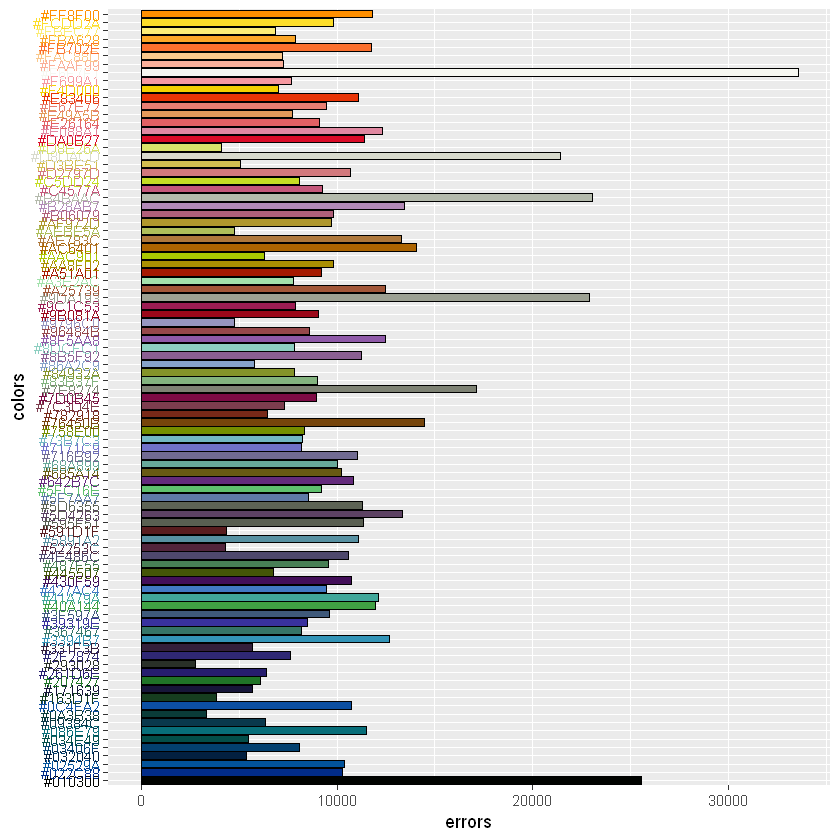

In [65]:
# plot things

error.df <- data.frame(colors,errors)

plot.error <- function(df){
    plot <- ggplot(df, aes(x=colors,y=errors, fill=colors)) +
                    geom_bar(stat="identity",show.legend=FALSE,colour='black') +
                    theme(axis.text.y = element_text(colour=df$colors)) + coord_flip() +
                    scale_color_manual(values = df$colors) + scale_fill_manual(values = df$colors)
                    
    ggsave('error_test.png',plot,height=20,width=10)
    return(plot)
}

plot.error(error.df)

Plot how everything changes as the dimensionality increases

In [307]:
# find the maximum value of a dataframe
colMax <- function(data) sapply(data, max, na.rm = TRUE)
colSort <- function(data, ...) sapply(data, sort, ...)

max.df <- function(df){
    
    max.row <- as.vector(colMax(df))
    
    return(max(max.row))
}

[1] 6.85

In [316]:
# make a df for the error across k dimensions

error.up2k <- function(max.k=15,mode='se',plot.mat=FALSE,normalise=FALSE){
    out.df <- as.data.frame(colors)
    
    if(plot.mat){
        folder.name <- paste('MDS_dim_plots/')
        dir.create(folder.name)
    }
    
    # calculate error for each dimension
    for(i in 1:max.k){
        mds.mat <- mds2df(cmdscale(data.dist, k = i, eig=TRUE))
        
        # normalise by max value if desired
        if(normalise){
            # empirical
            emp.data <- group.mean.mat.df
            emp.data[,1:93] <- emp.data[,1:93]/max.df(group.mean.mat.df[,1:93])
            
            # mds
            mds.mat$value <- mds.mat$value/max(mds.mat$value)
        }
        vals <- RMS.colors(group.mean.mat.df,
                           mds.mat,
                           mode = mode)
        out.df <- cbind(out.df,vals)
        
        # print some plots
        if(plot.mat){
            mat_name <- paste(folder.name,str_pad(i,4,pad='0'),'D',sep='')
            mean.matrix.plot(mds.mat,mat_name,skip.mean=TRUE,normalised=normalise)
        }
    }
    
    #fix the column names
    dim.names <- c(1:max.k)
    dim.names <- paste(dim.names,'D',sep='')
    names <- c('colors',dim.names)
    colnames(out.df) <- names
    
    out.df.long <- out.df %>% gather(dimension, error, -c(colors)) %>% mutate(dimension = fct_relevel(dimension, dim.names))
    
    
    return(out.df.long)
}

error.data <- error.up2k(max.k=25,plot.mat=TRUE,normalise=TRUE)
#head(error.data)

Warning message in dir.create(folder.name):
"'MDS_dim_plots' already exists"
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions 

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


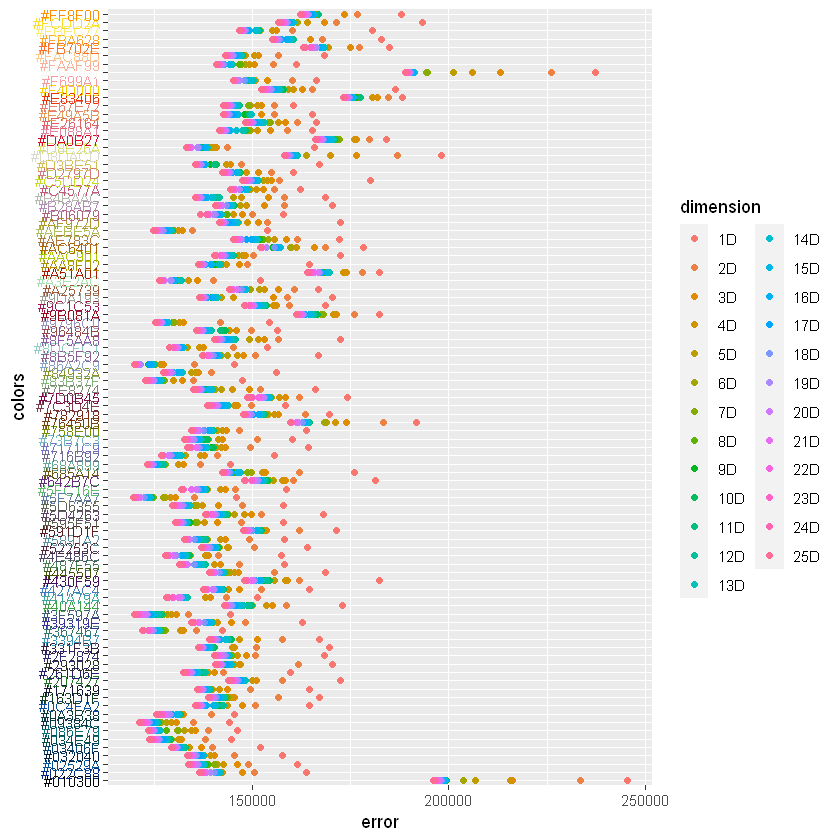

In [319]:
# try and plot it all together

plot.error.full <- function(df,log=FALSE){
    if(log){
        df$error <- log(df$error)
    }
    plot <- ggplot(df, aes(x=colors,y=error, color=dimension)) +
                    geom_point() +
                    #geom_point(show.legend=FALSE,colour='black') +
                    theme(axis.text.y = element_text(colour=df$colors)) + coord_flip() #+
                    #scale_fill_manual(values = df$colors) +
                    #scale_color_manual(values = df$colors)
                    
    ggsave('error_full_test.png',plot,height=20,width=10)
    return(plot)
}

plot.error.full(error.data)

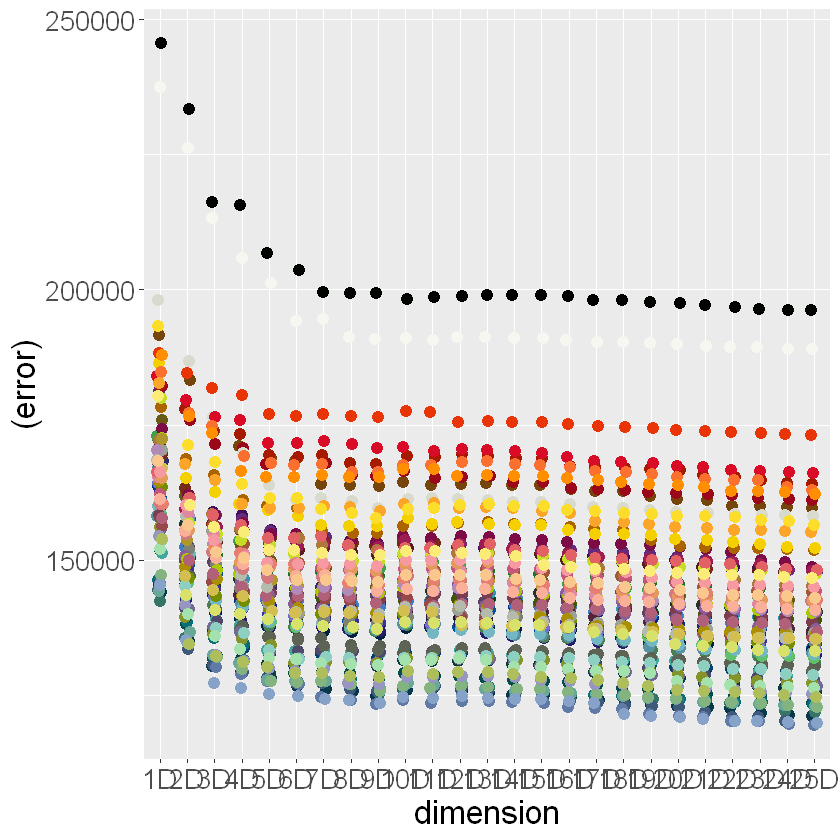

In [321]:
mean.error.full <- function(df,log=FALSE){
    if(log){
        df$error <- log(df$error)
    }
    plot <- ggplot(df, aes(x = dimension, y = (error))) +
            #geom_boxplot() + 
            geom_jitter(aes(color=colors),show.legend=FALSE,width=0.1,size=3) + scale_color_manual(values = df$colors) +
            theme(text = element_text(size = 20))
    
    ggsave('error_dimension_test.png',plot,height=20,width=20)
    return(plot)
}

mean.error.full(error.data)

In [71]:
# plot the 3D visualisation with the size of the points indicating the error value at that dimensionality

mds.vis.errors <- errors/max(errors)

In [87]:
visualise3d(data.dist,'MDS_error_test',error=TRUE,v.error = mds.vis.errors)

Warning message in dir.create(name):
"'MDS_error_test' already exists"
Warning message in dir.create(paste(name, "/animation/", sep = "")):
"'MDS_error_test\animation' already exists"
